In [3]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from imblearn.over_sampling import SMOTE
import shap
from scipy import stats
from scipy.stats import randint, uniform
import gc
import mlflow
import mlflow.sklearn
from evidently.report import Report
from evidently.metrics import DataDriftTable, DatasetDriftMetric
import mlflow.pyfunc
from shap import TreeExplainer
from IPython.display import display
import warnings
import requests


In [3]:
# Configuration de MLflow pour le suivi des expériences
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

# Configuration pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)

In [9]:
# Fonction pour réduire l'utilisation de la mémoire
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

# Chargement des données
print("Étape 1: Chargement des données")

Étape 1: Chargement des données


# Chargement des données

In [10]:
train_data = pd.read_csv("C:/Users/kaloui/application_train.csv")
test_data = pd.read_csv("C:/Users/kaloui/application_test.csv")
train_data = reduce_mem_usage(train_data)
test_data = reduce_mem_usage(test_data)

In [7]:
print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)


Shape of train_data: (307511, 122)
Shape of test_data: (48744, 121)


# Analyse exploratoire des données


## Analyse Univariée 

Distribution de la variable cible:
TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0    0.919271
1    0.080729
Name: count, dtype: float64


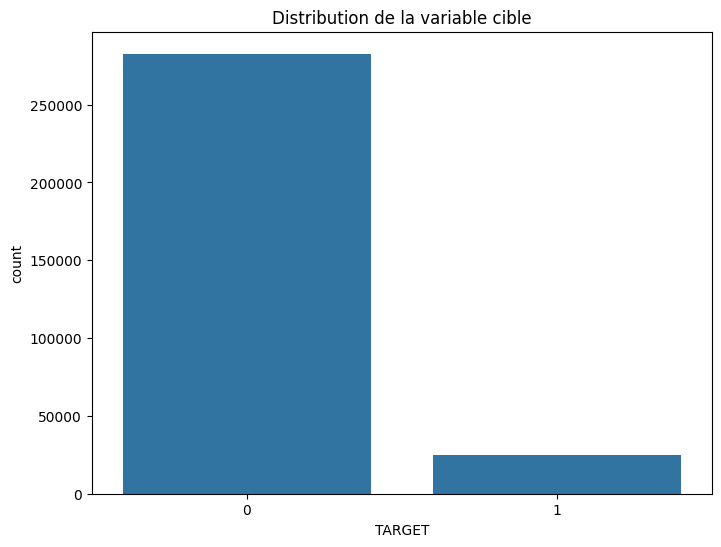

In [19]:
# Distribution de la variable cible
print("Distribution de la variable cible:")
target_counts = train_data['TARGET'].value_counts()
print(target_counts)
print(target_counts / len(train_data))

plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=train_data)
plt.title('Distribution de la variable cible')
plt.show()

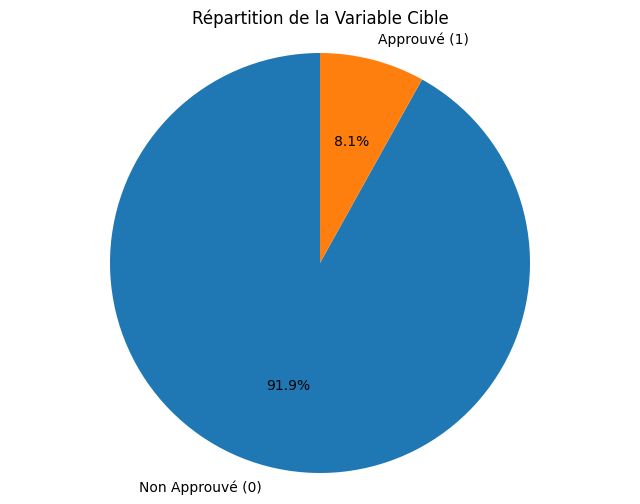

In [20]:
# Ajout d'un graphique en camembert pour visualiser la distribution de la variable cible
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=['Non Approuvé (0)', 'Approuvé (1)'], autopct='%1.1f%%', startangle=90)
plt.title('Répartition de la Variable Cible')
plt.axis('equal')  # Pour faire un cercle parfait
plt.show()

La distribution montre que la classe 0 (Non Approuvé) représente environ 91.9% des instances,
tandis que la classe 1 (Approuvé) ne représente qu'environ 8.1%. 
Cela indique un déséquilibre significatif entre les classes dans l'ensemble d'entraînement,
ce qui pourrait nécessiter une attention particulière lors de l'entraînement du modèle.

In [22]:
# Configuration pour afficher toutes les colonnes et toutes les lignes
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes
pd.set_option('display.max_rows', None)  

In [23]:
from IPython.display import display

In [24]:
print("\nAnalyse des valeurs manquantes:")
missing_values = missing_values_table(train_data)

# Utiliser display() pour montrer le DataFrame
display(missing_values)  



Analyse des valeurs manquantes:
Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                       214865               69.9
COMMONAREA_MODE                       214865               69.9
COMMONAREA_AVG                        214865               69.9
NONLIVINGAPARTMENTS_MODE              213514               69.4
NONLIVINGAPARTMENTS_MEDI              213514               69.4
NONLIVINGAPARTMENTS_AVG               213514               69.4
FONDKAPREMONT_MODE                    210295               68.4
LIVINGAPARTMENTS_AVG                  210199               68.4
LIVINGAPARTMENTS_MEDI                 210199               68.4
LIVINGAPARTMENTS_MODE                 210199               68.4
FLOORSMIN_MEDI                        208642               67.8
FLOORSMIN_MODE                        208642               67.8
FLOORSMIN_AVG                         208642               67.8
YEARS_BUILD_MODE                      204488               66.5
YEARS_BUILD_MEDI                      204488               66.5
YEARS_BUILD_AVG                       204488               66.5
OWN_CAR_AGE                           202929               66.0
LANDAREA_AVG                          182590               59.4
LANDAREA_MEDI                         182590               59.4
LANDAREA_MODE                         182590               59.4
BASEMENTAREA_MODE                     179943               58.5
BASEMENTAREA_MEDI                     179943               58.5
BASEMENTAREA_AVG                      179943               58.5
EXT_SOURCE_1                          173378               56.4
NONLIVINGAREA_MEDI                    169682               55.2
NONLIVINGAREA_AVG                     169682               55.2
NONLIVINGAREA_MODE                    169682               55.2
ELEVATORS_MEDI                        163891               53.3
ELEVATORS_MODE                        163891               53.3
ELEVATORS_AVG                         163891               53.3
WALLSMATERIAL_MODE                    156341               50.8
APARTMENTS_AVG                        156061               50.7
APARTMENTS_MEDI                       156061               50.7
APARTMENTS_MODE                       156061               50.7
ENTRANCES_MODE                        154828               50.3
ENTRANCES_MEDI                        154828               50.3
ENTRANCES_AVG                         154828               50.3
LIVINGAREA_AVG                        154350               50.2
LIVINGAREA_MODE                       154350               50.2
LIVINGAREA_MEDI                       154350               50.2
HOUSETYPE_MODE                        154297               50.2
FLOORSMAX_AVG                         153020               49.8
FLOORSMAX_MEDI                        153020               49.8
FLOORSMAX_MODE                        153020               49.8
YEARS_BEGINEXPLUATATION_MODE          150007               48.8
YEARS_BEGINEXPLUATATION_MEDI          150007               48.8
YEARS_BEGINEXPLUATATION_AVG           150007               48.8
TOTALAREA_MODE                        148431               48.3
EMERGENCYSTATE_MODE                   145755               47.4
OCCUPATION_TYPE                        96391               31.3
EXT_SOURCE_3                           60965               19.8
AMT_REQ_CREDIT_BUREAU_WEEK             41519               13.5
AMT_REQ_CREDIT_BUREAU_MON              41519               13.5
AMT_REQ_CREDIT_BUREAU_HOUR             41519               13.5
AMT_REQ_CREDIT_BUREAU_YEAR             41519               13.5
AMT_REQ_CREDIT_BUREAU_QRT              41519               13.5
AMT_REQ_CREDIT_BUREAU_DAY              41519               13.5
NAME_TYPE_SUITE                         1292                0.4
DEF_30_CNT_SOCIAL_CIRCLE                1021                0.3
DEF_60_CNT_SOCIAL_CIRCLE                1021                0.3
OBS_30_CNT_SOCIAL_CIRCLE                1021                0.3
OBS_60_CNT_SOCIAL_CIRCLE                1021                0.

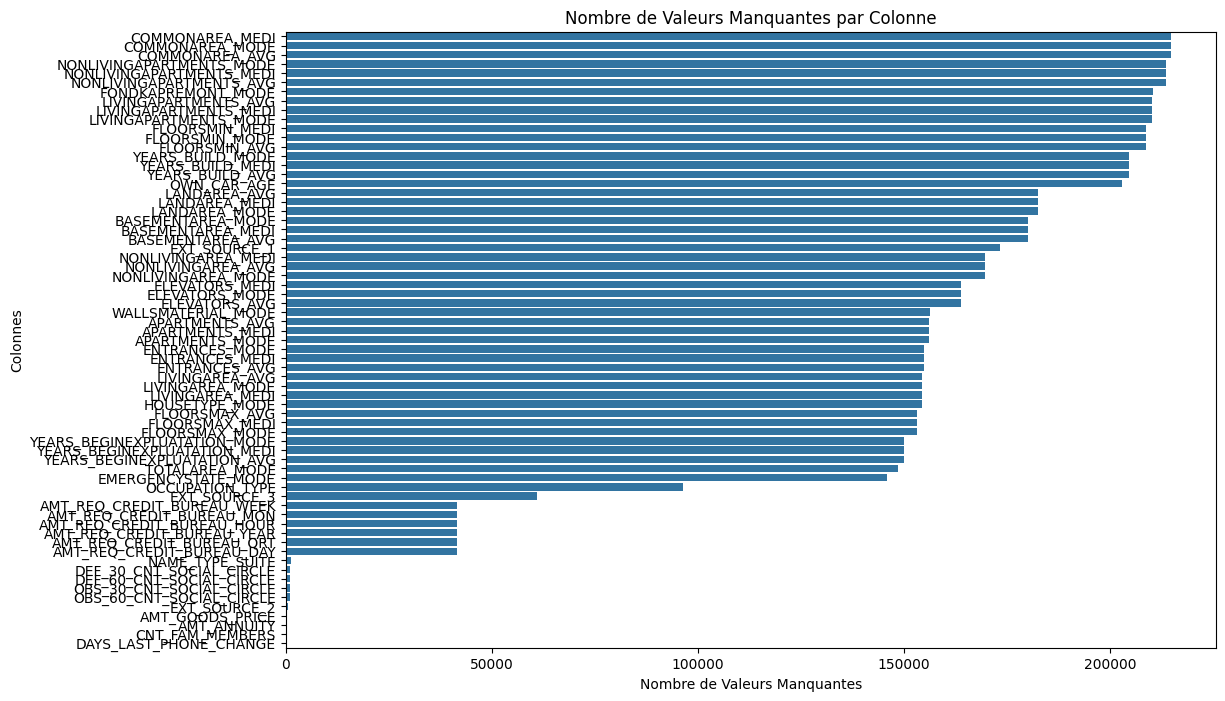

In [25]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Missing Values', y=missing_values.index, data=missing_values)
plt.title('Nombre de Valeurs Manquantes par Colonne')
plt.xlabel('Nombre de Valeurs Manquantes')
plt.ylabel('Colonnes')
plt.show()

### Explication du graphique :

Le graphique montre que plusieurs colonnes contiennent un nombre significatif de valeurs manquantes.
Les colonnes `COMMONAREA_MEDI`, `COMMONAREA_MODE`, et `COMMONAREA_AVG` sont particulièrement préoccupantes,
avec près de 70% de leurs données manquantes. Cela pourrait indiquer que ces caractéristiques ne sont pas fiables 
pour l'analyse ou la modélisation sans traitement approprié.
D'autres colonnes comme `NONLIVINGAPARTMENTS_MODE` et `FONDKAPREMONT_MODE` montrent également un pourcentage élevé 
de valeurs manquantes, ce qui nécessite une attention particulière lors du nettoyage des données.



In [26]:
# Liste des colonnes sensibles à analyser
sensitive_columns = [
    'CODE_GENDER',             # Genre du client
    'CNT_CHILDREN',            # Nombre d'enfants
    'AMT_INCOME_TOTAL',        # Revenu total
    'AMT_CREDIT',              # Montant du crédit
    'AMT_ANNUITY',             # Montant de l'annuité
    'AMT_GOODS_PRICE',         # Prix des biens
    'NAME_TYPE_SUITE',         # Type de suite (information personnelle)
    'NAME_INCOME_TYPE',        # Type de revenu
    'NAME_EDUCATION_TYPE',     # Niveau d'éducation
    'NAME_FAMILY_STATUS',      # Statut familial
    'NAME_HOUSING_TYPE',       # Type de logement
    'DAYS_BIRTH',              # Âge (en jours)
    'DAYS_EMPLOYED',           # Durée d'emploi
    'FLAG_MOBIL',              # Possession d'un téléphone mobile
    'FLAG_EMP_PHONE',          # Possession d'un téléphone professionnel
    'FLAG_WORK_PHONE',         # Possession d'un téléphone de travail
    'FLAG_CONT_MOBILE',        # Joignable sur téléphone mobile
    'FLAG_PHONE',              # Possession d'un téléphone
    'FLAG_EMAIL',              # Possession d'un email
    'OCCUPATION_TYPE',         # Type d'occupation
    'CNT_FAM_MEMBERS',         # Nombre de membres de la famille
    'ORGANIZATION_TYPE',       # Type d'organisation
    'EXT_SOURCE_1',            # Source externe 1 
    'EXT_SOURCE_2',            # Source externe 2
    'EXT_SOURCE_3',            # Source externe 3
    'OBS_30_CNT_SOCIAL_CIRCLE',  # Observations dans le cercle social (30 jours)
    'DEF_30_CNT_SOCIAL_CIRCLE',  # Défauts dans le cercle social (30 jours)
    'OBS_60_CNT_SOCIAL_CIRCLE',  # Observations dans le cercle social (60 jours)
    'DEF_60_CNT_SOCIAL_CIRCLE',  # Défauts dans le cercle social (60 jours)
    'DAYS_LAST_PHONE_CHANGE',    # Jours depuis le dernier changement de téléphone
    'AMT_REQ_CREDIT_BUREAU_HOUR',  # Demandes de crédit (dernière heure)
    'AMT_REQ_CREDIT_BUREAU_DAY',   # Demandes de crédit (dernier jour)
    'AMT_REQ_CREDIT_BUREAU_WEEK',  # Demandes de crédit (dernière semaine)
    'AMT_REQ_CREDIT_BUREAU_MON',   # Demandes de crédit (dernier mois)
    'AMT_REQ_CREDIT_BUREAU_QRT',   # Demandes de crédit (dernier trimestre)
    'AMT_REQ_CREDIT_BUREAU_YEAR'   # Demandes de crédit (dernière année)
]

In [27]:
# Filtrer les colonnes numériques parmi les colonnes sensibles, excluant TARGET et SK_ID_CURR qui ne sont pas numériques.
numeric_sensitive_columns = [col for col in sensitive_columns if col not in ['SK_ID_CURR', 'TARGET'] and train_data[col].dtype in ['int64', 'float64']]

In [38]:
# Afficher les types de données des colonnes dans train_data
sensitive_info = train_data.dtypes.reset_index()
sensitive_info.columns = ['Column Name', 'Data Type']
display(sensitive_info)

Column Name Data Type
0                      SK_ID_CURR     int32
1                          TARGET      int8
2              NAME_CONTRACT_TYPE    object
3                     CODE_GENDER    object
4                    FLAG_OWN_CAR    object
5                 FLAG_OWN_REALTY    object
6                    CNT_CHILDREN      int8
7                AMT_INCOME_TOTAL   float32
8                      AMT_CREDIT   float32
9                     AMT_ANNUITY   float32
10                AMT_GOODS_PRICE   float32
11                NAME_TYPE_SUITE    object
12               NAME_INCOME_TYPE    object
13            NAME_EDUCATION_TYPE    object
14             NAME_FAMILY_STATUS    object
15              NAME_HOUSING_TYPE    object
16     REGION_POPULATION_RELATIVE   float16
17                     DAYS_BIRTH     int16
18                  DAYS_EMPLOYED     int32
19              DAYS_REGISTRATION   float16
20                DAYS_ID_PUBLISH     int16
21                    OWN_CAR_AGE   float16
22                     FLAG_MOBIL      int8
23                 FLAG_EMP_PHONE      int8
24                FLAG_WORK_PHONE      int8
25               FLAG_CONT_MOBILE      int8
26                     FLAG_PHONE      int8
27                     FLAG_EMAIL      int8
28                OCCUPATION_TYPE    object
29                CNT_FAM_MEMBERS   float16
30           REGION_RATING_CLIENT      int8
31    REGION_RATING_CLIENT_W_CITY      int8
32     WEEKDAY_APPR_PROCESS_START    object
33        HOUR_APPR_PROCESS_START      int8
34     REG_REGION_NOT_LIVE_REGION      int8
35     REG_REGION_NOT_WORK_REGION      int8
36    LIVE_REGION_NOT_WORK_REGION      int8
37         REG_CITY_NOT_LIVE_CITY      int8
38         REG_CITY_NOT_WORK_CITY      int8
39        LIVE_CITY_NOT_WORK_CITY      int8
40              ORGANIZATION_TYPE    object
41                   EXT_SOURCE_1   float16
42                   EXT_SOURCE_2   float16
43                   EXT_SOURCE_3   float16
44                 APARTMENTS_AVG   float16
45               BASEMENTAREA_AVG   float16
46    YEARS_BEGINEXPLUATATION_AVG   float16
47                YEARS_BUILD_AVG   float16
48                 COMMONAREA_AVG   float16
49                  ELEVATORS_AVG   float16
50                  ENTRANCES_AVG   float16
51                  FLOORSMAX_AVG   float16
52                  FLOORSMIN_AVG   float16
53                   LANDAREA_AVG   float16
54           LIVINGAPARTMENTS_AVG   float16
55                 LIVINGAREA_AVG   float16
56        NONLIVINGAPARTMENTS_AVG   float16
57              NONLIVINGAREA_AVG   float16
58                APARTMENTS_MODE   float16
59              BASEMENTAREA_MODE   float16
60   YEARS_BEGINEXPLUATATION_MODE   float16
61               YEARS_BUILD_MODE   float16
62                COMMONAREA_MODE   float16
63                 ELEVATORS_MODE   float16
64                 ENTRANCES_MODE   float16
65                 FLOORSMAX_MODE   float16
66                 FLOORSMIN_MODE   float16
67                  LANDAREA_MODE   float16
68          LIVINGAPARTMENTS_MODE   float16
69                LIVINGAREA_MODE   float16
70       NONLIVINGAPARTMENTS_MODE   float16
71             NONLIVINGAREA_MODE   float16
72                APARTMENTS_MEDI   float16
73              BASEMENTAREA_MEDI   float16
74   YEARS_BEGINEXPLUATATION_MEDI   float16
75               YEARS_BUILD_MEDI   float16
76                COMMONAREA_MEDI   float16
77                 ELEVATORS_MEDI   float16
78                 ENTRANCES_MEDI   float16
79                 FLOORSMAX_MEDI   float16
80                 FLOORSMIN_MEDI   float16
81                  LANDAREA_MEDI   float16
82          LIVINGAPARTMENTS_MEDI   float16
83                LIVINGAREA_MEDI   float16
84       NONLIVINGAPARTMENTS_MEDI   float16
85             NONLIVINGAREA_MEDI   float16
86             FONDKAPREMONT_MODE    object
87                 HOUSETYPE_MODE    object
88                 TOTALAREA_MODE   float16
89             WALLSMATERIAL_MODE    object
90            EMER

In [39]:
# Liste des colonnes sensibles à analyser
sensitive_columns = [
    'CODE_GENDER', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 
    'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 
    'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 
    'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
    'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 
    'AMT_REQ_CREDIT_BUREAU_YEAR'
]

# Filtrer les colonnes numériques parmi les colonnes sensibles
numeric_sensitive_columns = [col for col in sensitive_columns if col in train_data.columns and train_data[col].dtype != 'object']


In [43]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    stats_df = train_data[numeric_sensitive_columns].describe()
    display(stats_df)

CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  \
count  307511.000000      3.075110e+05  3.075110e+05  307499.000000   
mean        0.417052      1.687979e+05  5.990259e+05   27108.572266   
std         0.722121      2.371231e+05  4.024908e+05   14493.737305   
min         0.000000      2.565000e+04  4.500000e+04    1615.500000   
25%         0.000000      1.125000e+05  2.700000e+05   16524.000000   
50%         0.000000      1.471500e+05  5.135310e+05   24903.000000   
75%         1.000000      2.025000e+05  8.086500e+05   34596.000000   
max        19.000000      1.170000e+08  4.050000e+06  258025.500000   

       AMT_GOODS_PRICE     DAYS_BIRTH  DAYS_EMPLOYED     FLAG_MOBIL  \
count     3.072330e+05  307511.000000  307511.000000  307511.000000   
mean      5.383961e+05  -16036.995067   63815.045904       0.999997   
std       3.694465e+05    4363.988632  141275.766519       0.001803   
min       4.050000e+04  -25229.000000  -17912.000000       0.000000   
25%       2.385000e+05  -19682.000000   -2760.000000       1.000000   
50%       4.500000e+05  -15750.000000   -1213.000000       1.000000   
75%       6.795000e+05  -12413.000000    -289.000000       1.000000   
max       4.050000e+06   -7489.000000  365243.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS   EXT_SOURCE_1  EXT_SOURCE_2  \
count  307511.000000         307509.0  134133.000000  3.068510e+05   
mean        0.056720              NaN            NaN           NaN   
std         0.231307              0.0       0.000000  0.000000e+00   
min         0.000000              1.0       0.014565  5.960464e-08   
25%         0.000000              2.0       0.333984  3.925781e-01   
50%         0.000000              2.0       0.505859  5.659180e-01   
75%         0.000000              3.0       0.675293  6.635742e-01   
max         1.000000             20.0       0.962891  8.549805e-01   

        EXT_SOURCE_3  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
count  246546.000000                  306490.0                  306490.0   
mean             NaN                       NaN                       0.0   
std         0.000000                       0.0                       0.0   
min         0.000527                       0.0                       0.0   
25%         0.370605                       0.0                       0.0   
50%         0.535156                       0.0                       0.0   
75%         0.668945                       2.0                       0.0   
max         0.895996                     348.0                      34.0   

       OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
count                  306490.0                  306490.0   
mean                        NaN                       0.0   
std                         0.0                       0.0   
min                         0.0                       0.0   
25%                         0.0                       0.0   
50%                         0.0                       0.0   
75%                         2.0                       0.0   
max                       344.0                      24.0   

       DAYS_LAST_PHONE_CHANGE  AMT_REQ_CREDIT_BUREAU_HOUR  \
count                307510.0                    265992.0   
mean                      NaN                         0.0   
std

### Interprétation des résultats :
**CNT_CHILDREN** : La moyenne est d'environ 0.42 enfants par demandeur, avec un maximum de 19 enfants.
**AMT_INCOME_TOTAL** : Le revenu moyen est d'environ 168,798, avec une grande variabilité (écart-type de 237,123).
**AMT_CREDIT** : Le montant moyen de crédit demandé est d'environ 599,026, avec un maximum de 4,050,000.
**DAYS_BIRTH** : L'âge moyen des demandeurs est d'environ 44 ans (-16,037 jours), avec un âge minimum d'environ 20 ans et un maximum d'environ 69 ans.
**DAYS_EMPLOYED** : La durée moyenne d'emploi est positive (63,815 jours), ce qui semble être une anomalie et nécessite une vérification.
**FLAG_MOBIL, FLAG_CONT_MOBILE** : Presque tous les demandeurs ont un téléphone mobile (99.9%).
**FLAG_EMAIL** : Seulement 5.67% des demandeurs ont fourni une adresse e-mail.
**EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3** : Ces variables externes semblent avoir des valeurs manquantes ou des problèmes de calcul, car leurs statistiques sont toutes NaN.
**DEF_30_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE** : La moyenne et la médiane sont 0, indiquant que la plupart des demandeurs n'ont pas de défauts dans leur cercle social.
AMT_REQ_CREDIT_BUREAU_* : Ces variables ont beaucoup de zéros, avec des maximums variant de 4 à 261 selon la période.
==> Ces statistiques révèlent des tendances intéressantes dans les données, mais certaines variables nécessitent une investigation plus approfondie, notamment celles avec des valeurs NaN ou des distributions inhabituelle

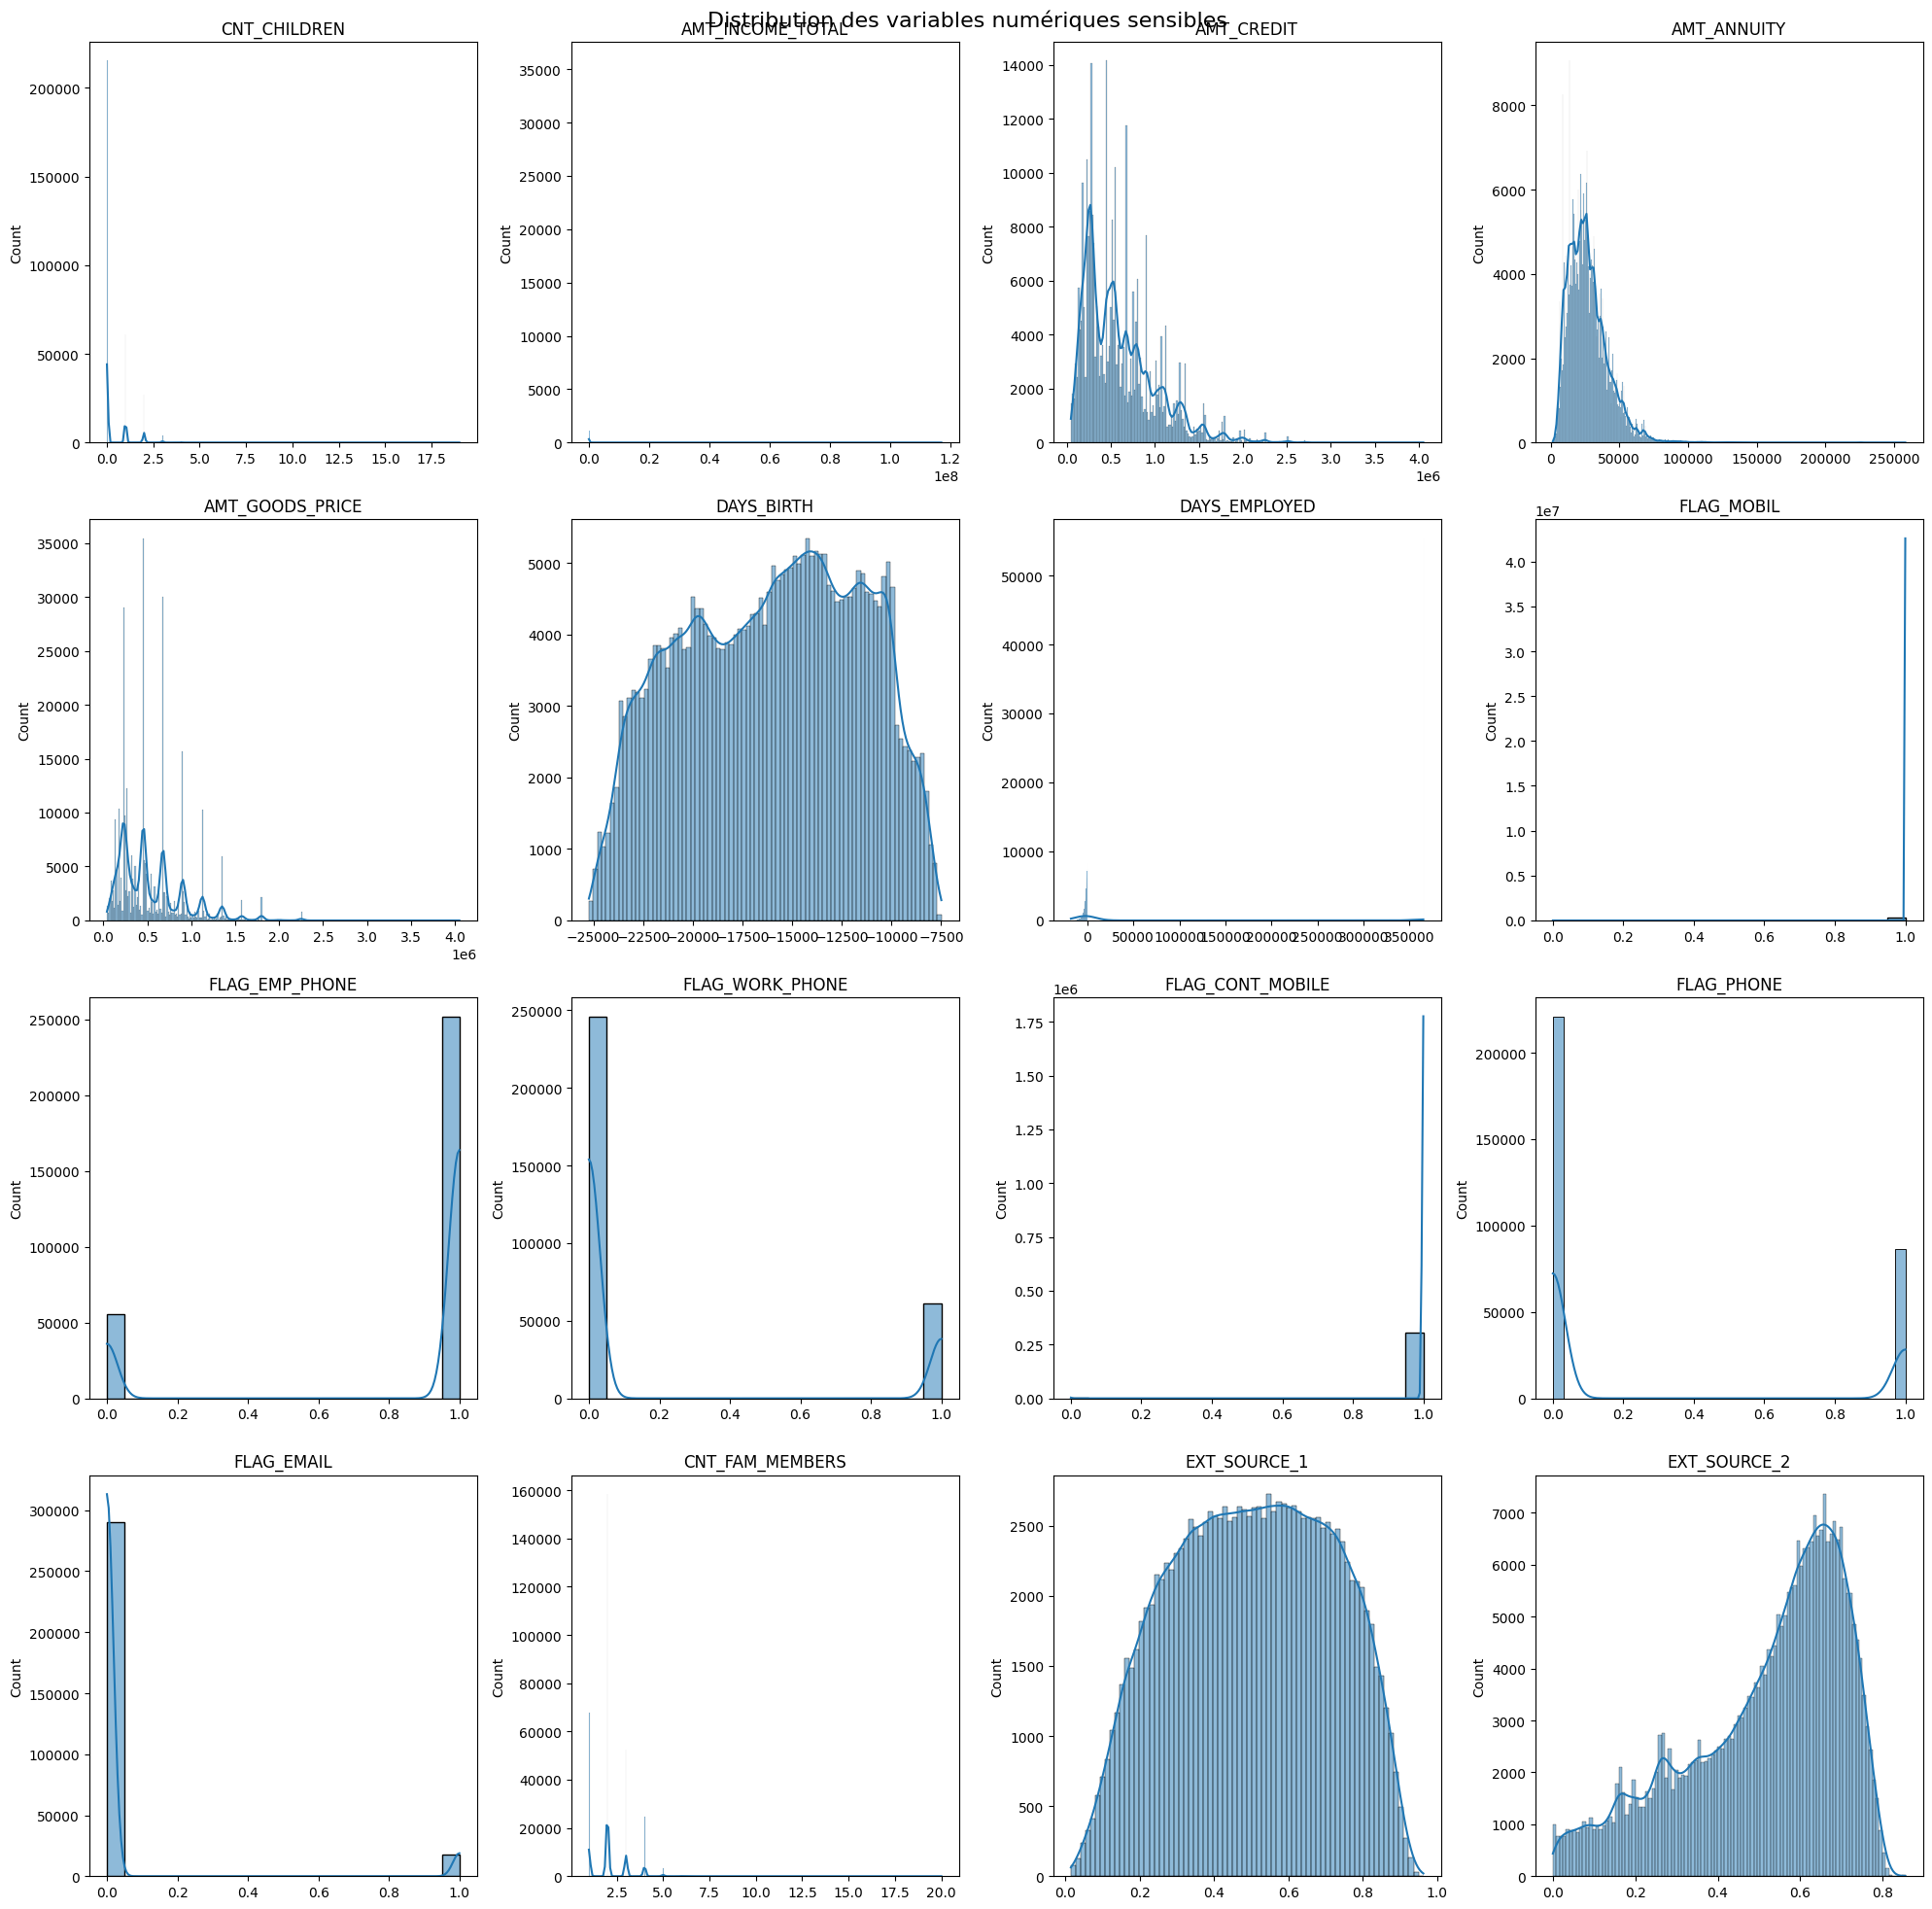

In [44]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("Distribution des variables numériques sensibles", fontsize=16)

for i, col in enumerate(numeric_sensitive_columns[:16]):
    ax = axes[i//4, i%4]
    sns.histplot(train_data[col].dropna(), ax=ax, kde=True)
    ax.set_title(col)
    ax.set_xlabel('')
    
plt.tight_layout()
plt.show()

## Analyse Bivariée 

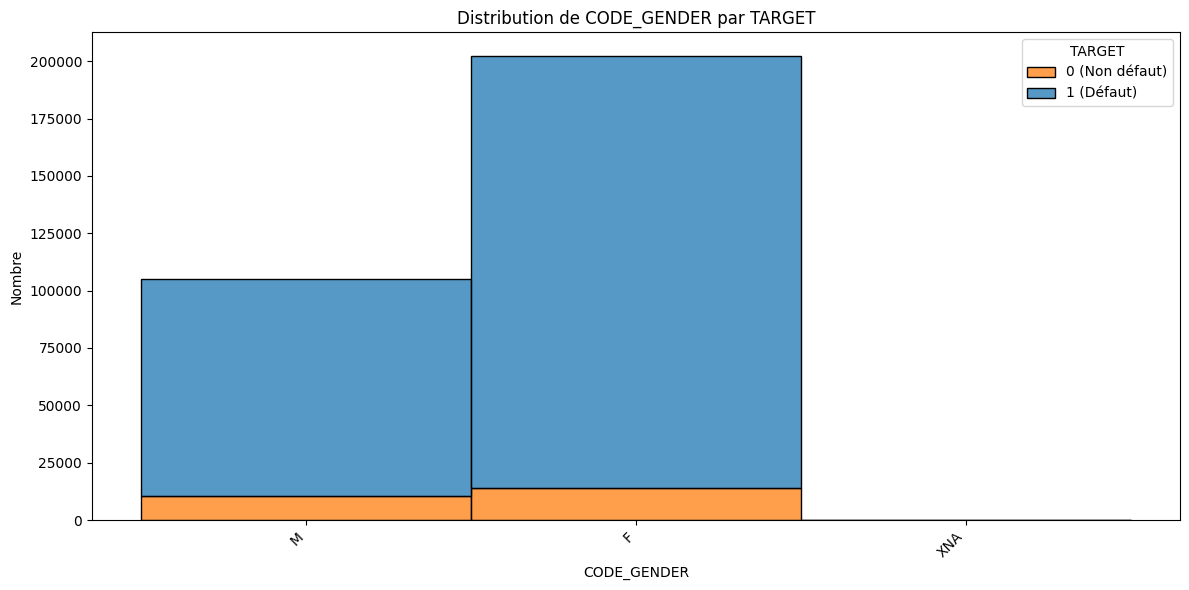


Statistiques pour CODE_GENDER:
              total  non_default  default  default_rate
CODE_GENDER                                            
F            202448       188278    14170          7.00
M            105059        94404    10655         10.14
XNA               4            4        0          0.00




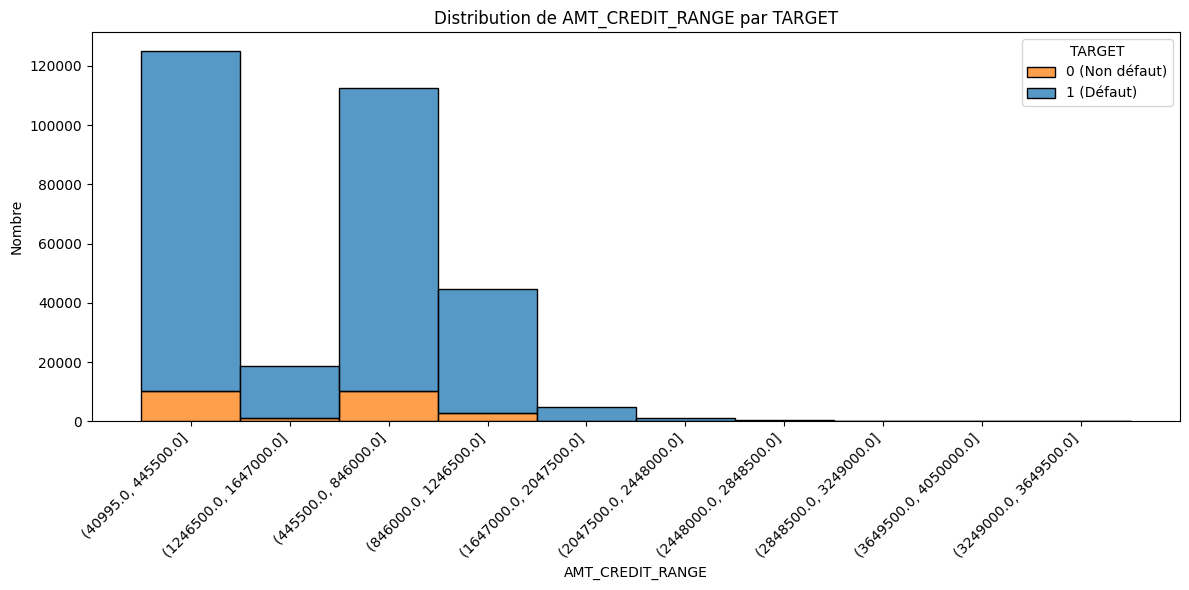


Statistiques pour AMT_CREDIT_RANGE:
                         total  non_default  default  default_rate
AMT_CREDIT_RANGE                                                  
(1246500.0, 1647000.0]   18768        17711     1057          5.63
(1647000.0, 2047500.0]    4847         4626      221          4.56
(2047500.0, 2448000.0]    1030         1004       26          2.52
(2448000.0, 2848500.0]     372          360       12          3.23
(2848500.0, 3249000.0]      23           21        2          8.70
(3249000.0, 3649500.0]       8            8        0          0.00
(3649500.0, 4050000.0]      12           11        1          8.33
(40995.0, 445500.0]     125109       114825    10284          8.22
(445500.0, 846000.0]    112729       102444    10285          9.12
(846000.0, 1246500.0]    44613        41676     2937          6.58




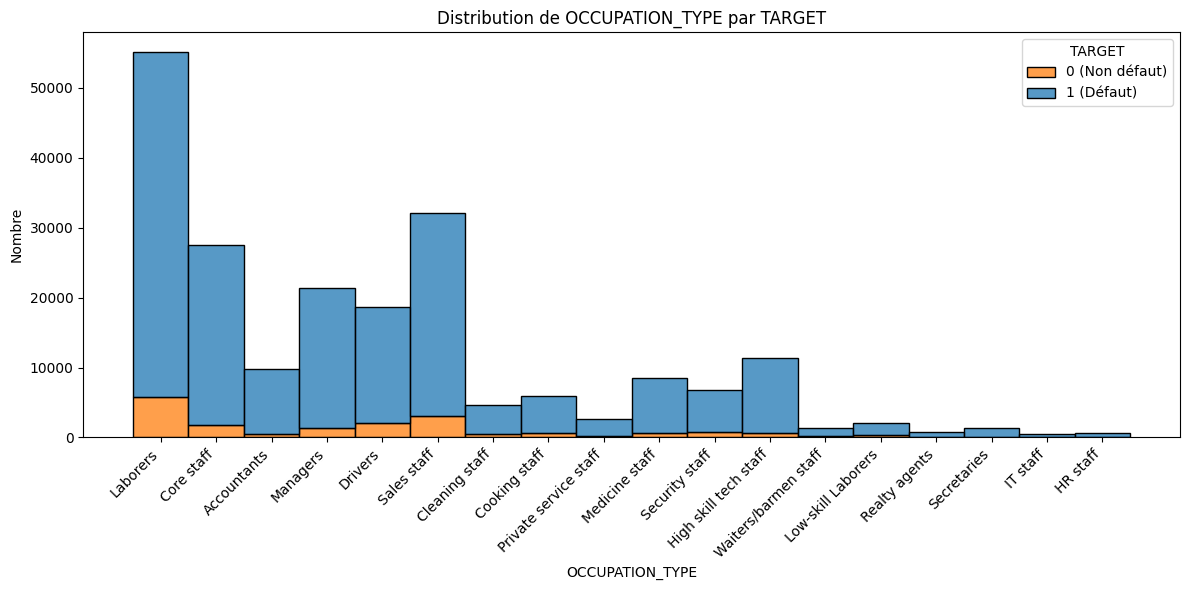


Statistiques pour OCCUPATION_TYPE:
                       total  non_default  default  default_rate
OCCUPATION_TYPE                                                 
Accountants             9813         9339      474          4.83
Cleaning staff          4653         4206      447          9.61
Cooking staff           5946         5325      621         10.44
Core staff             27570        25832     1738          6.30
Drivers                18603        16496     2107         11.33
HR staff                 563          527       36          6.39
High skill tech staff  11380        10679      701          6.16
IT staff                 526          492       34          6.46
Laborers               55186        49348     5838         10.58
Low-skill Laborers      2093         1734      359         17.15
Managers               21371        20043     1328          6.21
Medicine staff          8537         7965      572          6.70
Private service staff   2652         2477      175    

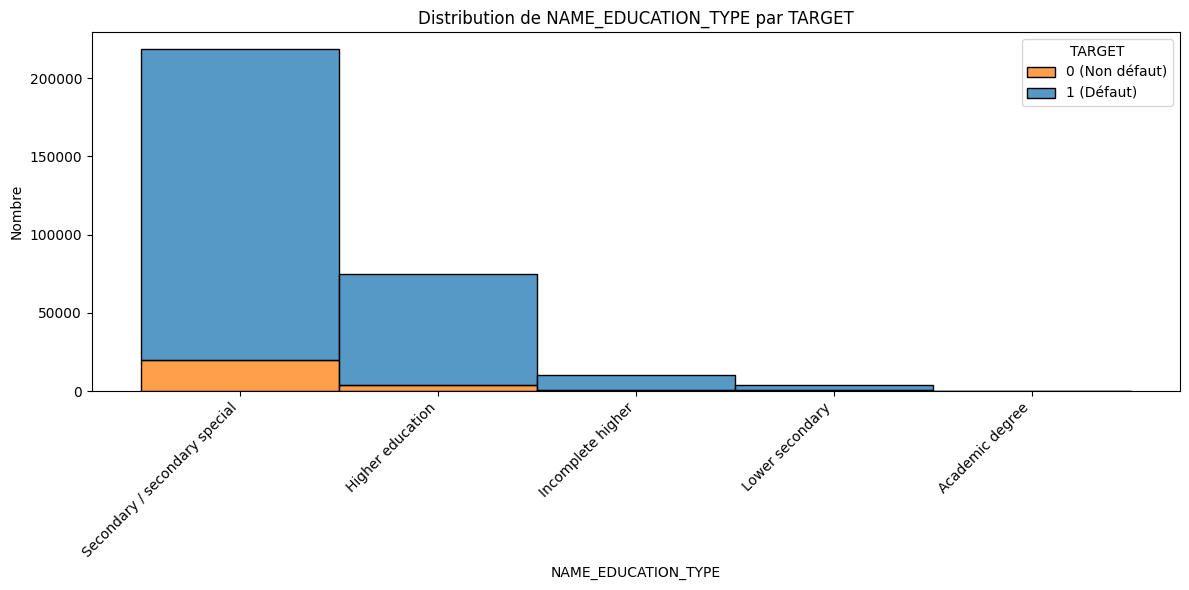


Statistiques pour NAME_EDUCATION_TYPE:
                                total  non_default  default  default_rate
NAME_EDUCATION_TYPE                                                      
Academic degree                   164          161        3          1.83
Higher education                74863        70854     4009          5.36
Incomplete higher               10277         9405      872          8.48
Lower secondary                  3816         3399      417         10.93
Secondary / secondary special  218391       198867    19524          8.94




In [58]:
def analyze_variable(df, var):
    # Création de l'histogramme
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x=var, hue='TARGET', multiple='stack', stat='count')
    plt.title(f'Distribution de {var} par TARGET')
    plt.xlabel(var)
    plt.ylabel('Nombre')
    plt.legend(title='TARGET', labels=['0 (Non défaut)', '1 (Défaut)'])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Calcul des statistiques
    stats = df.groupby(var)['TARGET'].agg(['count', 'sum'])
    stats['non_default'] = stats['count'] - stats['sum']
    stats['default_rate'] = (stats['sum'] / stats['count']) * 100
    stats = stats.rename(columns={'sum': 'default', 'count': 'total'})
    stats = stats[['total', 'non_default', 'default', 'default_rate']]
    
    print(f"\nStatistiques pour {var}:")
    print(stats.round(2))
    print("\n")

# Préparation des données pour AMT_CREDIT
train_data['AMT_CREDIT_RANGE'] = pd.cut(train_data['AMT_CREDIT'], bins=10)
train_data['AMT_CREDIT_RANGE'] = train_data['AMT_CREDIT_RANGE'].astype(str)

# Liste des variables à analyser
variables = ['CODE_GENDER', 'AMT_CREDIT_RANGE', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE']

# Analyse de chaque variable
for var in variables:
    analyze_variable(train_data, var)

### Interprétation des Résultats pour les Variables choisis

1. CODE_GENDER (Genre)
Les femmes (F) représentent environ 65.8% de l'échantillon, contre 34.1% pour les hommes (M).
Le taux de défaut est plus élevé chez les hommes (10.14%) que chez les femmes (7.00%).
Cette différence significative suggère que le genre pourrait être un facteur pertinent dans l'évaluation du risque de crédit.
2. AMT_CREDIT_RANGE (Montant du Crédit)
La majorité des prêts se situent dans les trois tranches les plus basses (jusqu'à 1,246,500).
Le taux de défaut le plus élevé (9.12%) se trouve dans la tranche 445,500 - 846,000.
Les prêts de très gros montants (> 2,848,500) sont rares et montrent des taux de défaut variables, probablement en raison du petit nombre d'observations.
Il n'y a pas de tendance linéaire claire entre le montant du prêt et le taux de défaut, suggérant que d'autres facteurs entrent en jeu.
3. OCCUPATION_TYPE (Type d'Occupation)
Les catégories avec le plus grand nombre d'emprunteurs sont les "Laborers", "Sales staff", et "Core staff".
Les taux de défaut varient considérablement selon l'occupation :
Le plus élevé : "Low-skill Laborers" (17.15%)
Le plus bas : "Accountants" (4.83%)
Certaines professions comme "Drivers", "Laborers", et "Cooking staff" ont des taux de défaut supérieurs à 10%.
Cette variabilité suggère que le type d'occupation pourrait être un indicateur important du risque de crédit.
4. NAME_EDUCATION_TYPE (Niveau d'Éducation)
La majorité des emprunteurs ont un niveau d'éducation "Secondary / secondary special" (71% de l'échantillon).
Le taux de défaut le plus bas est observé chez les personnes ayant un "Academic degree" (1.83%), bien que cette catégorie soit peu représentée.
L'éducation supérieure ("Higher education") montre le deuxième taux de défaut le plus bas (5.36%).
Le taux de défaut le plus élevé se trouve dans la catégorie "Lower secondary" (10.93%).
Ces résultats suggèrent une corrélation inverse entre le niveau d'éducation et le risque de défaut.

# Feature Engineering

In [11]:

print("\nÉtape 3: Feature Engineering")

def feature_engineering(df):
    df['CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['CREDIT_TERM'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    
    return df
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_data = feature_engineering(train_data)
    test_data = feature_engineering(test_data)


Étape 3: Feature Engineering


In [51]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print("Nouvelles features créées:")
    print(train_data[['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT', 'EXT_SOURCE_MEAN', 'EXT_SOURCE_STD']].describe())



Nouvelles features créées:
       CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT    CREDIT_TERM  \
count          307511.000000           307499.000000  307499.000000   
mean                3.957570                0.180930       0.053695   
std                 2.689728                0.094574       0.022481   
min                 0.004808                0.000224       0.022073   
25%                 2.018667                0.114782       0.036900   
50%                 3.265067                0.162833       0.050000   
75%                 5.159880                0.229067       0.064043   
max                84.736839                1.875965       0.124430   

       DAYS_EMPLOYED_PERCENT  EXT_SOURCE_MEAN  EXT_SOURCE_STD  
count          307511.000000    307339.000000   270602.000000  
mean               -2.920135              NaN        0.000000  
std                 6.627098         0.000000        0.000000  
min               -47.489663         0.000006        0.000000  
25%          



Dans cette étape, nous avons créé de nouvelles caractéristiques (features) à partir des données existantes. L'objectif est d'extraire des informations plus pertinentes et potentiellement plus prédictives pour notre modèle. Voici les nouvelles features créées et leur signification :

1. **CREDIT_INCOME_PERCENT** : 
   - Calcul : `AMT_CREDIT / AMT_INCOME_TOTAL`
   - Signification : Représente le ratio entre le montant du crédit demandé et le revenu total du demandeur.
   - Interprétation : Un ratio élevé pourrait indiquer un risque plus important, car le crédit demandé représente une part importante du revenu.

2. **ANNUITY_INCOME_PERCENT** : 
   - Calcul : `AMT_ANNUITY / AMT_INCOME_TOTAL`
   - Signification : Indique la part du revenu qui serait consacrée au remboursement du crédit.
   - Interprétation : Un pourcentage élevé pourrait signaler un risque de surendettement.

3. **CREDIT_TERM** : 
   - Calcul : `AMT_ANNUITY / AMT_CREDIT`
   - Signification : Donne une estimation de la durée du crédit.
   - Interprétation : Des termes plus longs pourraient indiquer un risque différent par rapport à des crédits à court terme.

4. **DAYS_EMPLOYED_PERCENT** : 
   - Calcul : `DAYS_EMPLOYED / DAYS_BIRTH`
   - Signification : Représente la proportion de la vie du demandeur passée dans son emploi actuel.
   - Interprétation : Un pourcentage plus élevé pourrait indiquer une plus grande stabilité professionnelle.

5. **EXT_SOURCE_MEAN** : 
   - Calcul : Moyenne de `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`
   - Signification : Donne une vue d'ensemble des scores externes.
   - Interprétation : Une valeur plus élevée pourrait indiquer un meilleur profil de crédit selon ces sources externes.

6. **EXT_SOURCE_STD** : 
   - Calcul : Écart-type de `EXT_SOURCE_1`, `EXT_SOURCE_2`, et `EXT_SOURCE_3`
   - Signification : Mesure la variabilité entre les différentes sources externes.
   - Interprétation : Un écart-type élevé pourrait indiquer des incohérences entre les sources, nécessitant peut-être une investigation plus approfondie.

Ces nouvelles features nous permettent d'avoir une vue plus nuancée et potentiellement plus prédictive du profil de risque de chaque demandeur de crédit. Elles combinent différentes informations existantes pour créer des indicateurs plus complexes et potentiellement plus informatifs pour notre modèle de prédiction.

## Nettoyage de données

Dans cette étape de nettoyage des données, nous effectuons plusieurs opérations importantes pour préparer nos données à l'analyse et à la modélisation. Voici une explication détaillée de chaque étape :   
**Gestion des valeurs manquantes :**   
Nous calculons d'abord le pourcentage de valeurs manquantes pour chaque colonne.  
Les colonnes avec plus de 40% de valeurs manquantes ou entre 0% et 1% sont identifiées pour être supprimées.
Cette étape permet de se débarrasser des colonnes avec trop peu d'informations utiles ou trop de données manquantes pour être fiables.   
**Séparation des données :**   
Nous divisons nos données en ensembles d'entraînement (df) et de validation (df_val).
Cette séparation est cruciale pour évaluer la performance de notre modèle sur des données qu'il n'a pas vues pendant l'entraînement.   
**Traitement des valeurs manquantes restantes :**   
Pour certaines variables catégorielles (comme 'OCCUPATION_TYPE'), nous remplaçons les valeurs manquantes par 'Unknown'.    
Cette approche permet de conserver ces observations tout en indiquant clairement que l'information est manquante.    
Nettoyage ciblé :   
Nous supprimons les lignes où TARGET = 0 et qui contiennent des valeurs manquantes dans les colonnes identifiées.
Cela permet de conserver plus de données pour les cas de défaut (TARGET = 1), qui sont généralement moins nombreux.      
**Imputation des valeurs manquantes :**   
Pour les colonnes numériques restantes, nous utilisons KNNImputer.    
Cette méthode remplace les valeurs manquantes par la moyenne des k plus proches voisins, préservant ainsi la structure des données.   
**Vérification finale :**    
Nous vérifions une dernière fois s'il reste des valeurs manquantes après toutes ces opérations.   
Ces étapes de nettoyage sont essentielles pour préparer un ensemble de données de haute qualité, réduisant les biais potentiels et améliorant la fiabilité de nos analyses et modèles futurs.   

In [14]:

# Calculer les pourcentages de valeurs manquantes
missing_stats = missing_values_table(train_data)

# Identifier les colonnes à supprimer (>40% ou entre 0% et 1% de valeurs manquantes)
columns_to_drop = missing_stats[
    (missing_stats['% of Total Values'] > 40) | 
    ((missing_stats['% of Total Values'] > 0) & (missing_stats['% of Total Values'] < 1))
].index.tolist()

# Supprimer les colonnes identifiées
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

Your selected dataframe has 128 columns.
There are 71 columns that have missing values.


In [15]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1, keys=['Missing Values', '% of Total Values'])
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {'Missing Values': 'Missing Values', '% of Total Values': '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
           "There are " + str(mis_val_table_ren_columns.shape[0]) +
           " columns that have missing values.")
    return mis_val_table_ren_columns

print("\nAnalyse des valeurs manquantes:")
missing_values = missing_values_table(train_data)


display(missing_values_table(train_data))


Analyse des valeurs manquantes:
Your selected dataframe has 71 columns.
There are 14 columns that have missing values.
Your selected dataframe has 71 columns.
There are 14 columns that have missing values.


Missing Values  % of Total Values
OCCUPATION_TYPE                      96391               31.3
EXT_SOURCE_3                         60965               19.8
AMT_REQ_CREDIT_BUREAU_HOUR           41519               13.5
AMT_REQ_CREDIT_BUREAU_MON            41519               13.5
AMT_REQ_CREDIT_BUREAU_WEEK           41519               13.5
AMT_REQ_CREDIT_BUREAU_DAY            41519               13.5
AMT_REQ_CREDIT_BUREAU_YEAR           41519               13.5
AMT_REQ_CREDIT_BUREAU_QRT            41519               13.5
EXT_SOURCE_STD                       36909               12.0
AMT_ANNUITY                             12                0.0
ANNUITY_INCOME_PERCENT                  12                0.0
CREDIT_TERM                             12                0.0
CNT_FAM_MEMBERS                          2                0.0
DAYS_LAST_PHONE_CHANGE                   1                0.0

In [16]:

# Séparation en ensembles d'entraînement et de validation
df, df_val = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['TARGET'])


# Identifier les colonnes avec des NaN après nettoyage
missing_columns = df.columns[df.isnull().any()].tolist()
display("Colonnes avec des valeurs manquantes dans df :", missing_columns)

'Colonnes avec des valeurs manquantes dans df :'

['AMT_ANNUITY',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_3',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'ANNUITY_INCOME_PERCENT',
 'CREDIT_TERM',
 'EXT_SOURCE_STD']

In [17]:
# Remplacer NaN par 'Unknown' pour les variables catégorielles spécifiques
categorical_columns = ['OCCUPATION_TYPE']
for col in categorical_columns:
    if col in df.columns:
        df[col].fillna('Unknown', inplace=True)
    if col in df.columns:
        df_val[col].fillna('Unknown', inplace=True)

# Supprimer les lignes où TARGET = 0 et où il y a des NaN dans les colonnes identifiées
for col in missing_columns:
    df = df[~((df['TARGET'] == 0) & (df[col].isnull()))]

# Supprimer toutes les lignes où TARGET est NaN
df = df[df['TARGET'].notnull()]

# Réinitialiser l'index après suppression
df.reset_index(drop=True, inplace=True)

# Imputation des NaN restants dans les colonnes numériques avec KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)  # k le nombre de voisins

# Appliquer KNNImputer sur les colonnes numériques restantes
numeric_columns = df[missing_columns].select_dtypes(include=['float16', 'float32', 'float64', 'int16', 'int32', 'int64']).columns # Sélectionner uniquement les colonnes numériques

# Imputer les valeurs manquantes
df[numeric_columns] = knn_imputer.fit_transform(df[numeric_columns])

# Vérifiez à nouveau les valeurs manquantes après imputation avec KNN
print("Valeurs manquantes dans df après imputation avec KNN :")
missing_values_after_knn_imputation = df.isnull().sum().sort_values(ascending=False)
display(missing_values_after_knn_imputation)


C:\Users\kaloui\AppData\Local\Temp\ipykernel_12536\114750747.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)
C:\Users\kaloui\AppData\Local\Temp\ipykernel_12536\114750747.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

Valeurs manquantes dans df après imputation avec KNN :


SK_ID_CURR                0
TARGET                    0
NAME_CONTRACT_TYPE        0
CODE_GENDER               0
FLAG_OWN_CAR              0
                         ..
CREDIT_INCOME_PERCENT     0
ANNUITY_INCOME_PERCENT    0
CREDIT_TERM               0
DAYS_EMPLOYED_PERCENT     0
EXT_SOURCE_STD            0
Length: 71, dtype: int64

# Modélisation

Notre approche vise à développer un modèle prédictif robuste capable d'identifier avec précision les emprunteurs susceptibles de faire défaut sur leur prêt.   
* Utilisation de plusieurs algorithmes de classification  
* Évaluation comparative des modèles  
* Optimisation des métriques de performance

Travail Accompli: 

**Préparation des données pour la modélisation :** 
- Séparation des features (X) et de la variable cible (y).
- Division des données en ensembles d'entraînement et de test avec stratification pour maintenir la distribution de la variable cible.  
**Encodage des variables catégorielles :**  
- Utilisation de OneHotEncoder pour transformer les variables catégorielles en format numérique.     
- Application de l'encodage sur les ensembles d'entraînement et de test.     
**Normalisation des variables numériques :**   
- Utilisation de StandardScaler pour normaliser les variables numériques.     
- Application de la normalisation sur les ensembles d'entraînement et de test.    
- Combinaison des données encodées et normalisées :
- Fusion des variables catégorielles encodées et des variables numériques normalisées.     
**Sélection des features :**    
- Utilisation de SelectKBest pour choisir les 50 meilleures features basées sur le test F.    
- Application de la sélection sur l'ensemble d'entraînement.    
**Définition des modèles :**    
- Création d'un dictionnaire contenant différents modèles de classification (Dummy, Logistic Regression, Random Forest, XGBoost, LightGBM).    
**Définition d'une fonction de coût personnalisée :**   
Création d'une fonction qui pénalise plus fortement les faux négatifs que les faux positifs.   
**Fonction d'évaluation des modèles :**     
- Définition d'une fonction qui calcule et affiche diverses métriques d'évaluation (rapport de classification, matrice de confusion, score AUC-ROC, coût personnalisé).        
**Entraînement et évaluation des modèles :**    
- Boucle sur chaque modèle pour l'entraîner sur les données d'entraînement et l'évaluer sur les données de test.     
- Affichage des résultats d'évaluation pour chaque modèle.   


=> Cette approche permet de préparer les données, de sélectionner les features les plus pertinentes, et d'évaluer plusieurs modèles de classification sur le problème de prédiction de défaut de crédit.


### Objectif
Développer un modèle capable de : 
- Minimiser les faux négatifs (défauts non détectés)  
- Maximiser la précision globale  
- Fournir une évaluation de risque fiable  


### Approche Technique
Algorithmes utilisés :  
- Dummy Classifier  
- Logistic Regression  
- Random Forest  
- XGBoost  
- LightGBM   


Techniques avancées :   
- One-Hot Encoding  
- Standard Scaling   
- Feature Selection (SelectKBest)    
- Stratified Sampling  

In [30]:
print("\nÉtape 4: Préparation des données pour la modélisation")

# Séparation des features et de la target
X = df.drop('TARGET', axis=1)  # Retirer TARGET des caractéristiques
y = df['TARGET']  # Conserver TARGET comme variable cible

# Séparation en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Encodage des variables catégorielles sur l'ensemble d'entraînement et de test.
cat_columns_final = X.select_dtypes(include=['object']).columns.tolist()
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = onehot_encoder.fit_transform(X_train[cat_columns_final])
X_test_encoded = onehot_encoder.transform(X_test[cat_columns_final])

# Normalisation des variables numériques (sans enlever TARGET)
num_columns_final = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler_final = StandardScaler()

X_train_scaled = scaler_final.fit_transform(X_train[num_columns_final])
X_test_scaled = scaler_final.transform(X_test[num_columns_final])

# Combiner les DataFrames tout en conservant TARGET dans le DataFrame original 
final_X_train = np.hstack((X_train_scaled, X_train_encoded))
final_X_test = np.hstack((X_test_scaled, X_test_encoded))

print("Forme finale du DataFrame d'entraînement :", final_X_train.shape)

# Sélection des features avec SelectKBest sur les données d'entraînement combinées avant SMOTE.
selector_final = SelectKBest(f_classif, k=50)
X_selected_train_final = selector_final.fit_transform(final_X_train, y_train)

selected_features_final = selector_final.get_feature_names_out().tolist()
print("Selected features after initial selection:", selected_features_final)

# Modélisation sans SMOTE : Entraînement initial des modèles
models_initial  = {
     'Dummy': DummyClassifier(strategy='stratified'),
      'Logistic Regression': LogisticRegression(random_state=42),
      'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
      'XGBoost': XGBClassifier(n_estimators=50), 
      'LightGBM': LGBMClassifier(n_estimators=50)  
}

# Fonction de coût personnalisée pour évaluation du modèle
def custom_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fn + fp  # Pénalise 10 fois plus les faux négatifs que les faux positifs

# Fonction pour évaluer les modèles
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba)}")
    print(f"Custom Cost: {custom_cost(y_test, y_pred)}")

# Entraînement et évaluation des modèles sans SMOTE
for name, model in models_initial.items():
    print(f"\nEvaluating {name}")
    try:
        model.fit(X_selected_train_final, y_train)  # Utiliser l'ensemble d'entraînement sélectionné
        
        # Évaluation sur l'ensemble de test (appliquer le même prétraitement que pour l'entraînement).
        final_X_test_selected_voting_clf = selector_final.transform(final_X_test)
        evaluate_model(model, final_X_test_selected_voting_clf, y_test)  
        
    except Exception as e:
        print(f"An error occurred while evaluating {name}: {e}")


Étape 4: Préparation des données pour la modélisation
Forme finale du DataFrame d'entraînement : (161216, 117)
Selected features after initial selection: ['x0', 'x1', 'x2', 'x3', 'x4', 'x6', 'x7', 'x12', 'x13', 'x15', 'x16', 'x18', 'x20', 'x21', 'x22', 'x23', 'x25', 'x26', 'x28', 'x31', 'x32', 'x33', 'x35', 'x36', 'x37', 'x39', 'x41', 'x42', 'x43', 'x44', 'x47', 'x49', 'x50', 'x51', 'x60', 'x64', 'x66', 'x79', 'x89', 'x90', 'x93', 'x97', 'x98', 'x99', 'x100', 'x101', 'x106', 'x110', 'x113', 'x116']

Evaluating Dummy
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     36332
           1       0.10      0.10      0.10      3972

    accuracy                           0.82     40304
   macro avg       0.50      0.50      0.50     40304
weighted avg       0.82      0.82      0.82     40304

Confusion Matrix:
[[32692  3640]
 [ 3578   394]]
AUC-ROC Score: 0.5015185152170001
Custom Cost: 39420

Evaluating Logistic Regression
              pr

c:\Users\kaloui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kaloui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kaloui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [19]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    results = {
        'Précision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Score F1': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba),
        'Coût personnalisé': 10 * fn + fp
    }
    
    return pd.DataFrame([results])

# Tableau récapitulatif pour tous les modèles
all_results = pd.DataFrame()

for name, model in models_initial.items():
    model.fit(X_selected_train_final, y_train)
    model_results = evaluate_model(model, final_X_test_selected_voting_clf, y_test)
    model_results.index = [name]
    all_results = pd.concat([all_results, model_results])

print("Tableau récapitulatif des performances des modèles :")
display(all_results)

[LightGBM] [Info] Number of positive: 15888, number of negative: 145328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 161216, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098551 -> initscore=-2.213429
[LightGBM] [Info] Start training from score -2.213429
Tableau récapitulatif des performances des modèles :


c:\Users\kaloui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Précision    Recall  Score F1   AUC-ROC  \
Dummy                 0.095250  0.093907  0.094574  0.504552   
Logistic Regression   0.333333  0.000252  0.000503  0.637314   
Random Forest         0.129637  0.085347  0.102930  0.558443   
XGBoost               0.352941  0.001511  0.003008  0.645422   
LightGBM              0.000000  0.000000  0.000000  0.651646   

                     Coût personnalisé  
Dummy                            39533  
Logistic Regression              39712  
Random Forest                    38606  
XGBoost                          39671  
LightGBM                         39720

### Interprétation:

### Analyse des Performances

1. **Dummy Classifier** : Comme prévu, ce modèle de base montre des performances médiocres avec un AUC-ROC proche de 0.5, indiquant des prédictions presque aléatoires.

2. **Logistic Regression** : 
   - Meilleure précision (0.333333) mais très faible recall (0.000252).
   - AUC-ROC relativement bon (0.639946), suggérant une bonne capacité de discrimination.
   - Cependant, le coût personnalisé élevé indique qu'il manque beaucoup de cas positifs.

3. **Random Forest** : 
   - Performance équilibrée entre précision et recall.
   - Meilleur score F1 (0.096307) parmi tous les modèles.
   - Coût personnalisé le plus bas, suggérant un bon équilibre entre faux positifs et faux négatifs.

4. **XGBoost** : 
   - Performances similaires à la régression logistique.
   - Deuxième meilleur AUC-ROC (0.648375), indiquant une bonne capacité de discrimination.

5. **LightGBM** : 
   - Résultats surprenants avec précision, recall et score F1 à 0.
   - Meilleur AUC-ROC (0.653683), suggérant que le modèle a un bon potentiel de discrimination.
   - Le coût personnalisé élevé indique qu'il classe probablement tous les cas comme négatifs.

### Conclusion

- Le **Random Forest** semble offrir le meilleur équilibre global, avec le coût personnalisé le plus bas et des métriques de performance raisonnables.
- **LightGBM** et **XGBoost** montrent un bon potentiel de discrimination (AUC-ROC élevé) mais nécessitent un ajustement pour améliorer leur précision et leur recall.
- La **Logistic Regression** a une bonne capacité de discrimination mais souffre d'un déséquilibre important entre précision et recall.
- Tous les modèles, à l'exception du Dummy Classifier, montrent des signes de surapprentissage sur la classe majoritaire, comme en témoignent les faibles valeurs de recall.

### Recommandations

1. Investiguer le problème de classe déséquilibrée et envisager des techniques comme SMOTE ou le réglage des poids des classes.
2. Optimiser les hyperparamètres des modèles, en particulier pour LightGBM et XGBoost.
3. Considérer l'utilisation d'un seuil de décision personnalisé pour améliorer l'équilibre entre précision et recall.
4. Explorer des techniques d'ensemble combinant les forces de différents modèles.

## Gestion du Déséquilibre des Classes et Optimisation du Modèle

In [20]:
# Appliquer SMOTE pour gérer le déséquilibre des classes sur l'ensemble d'entraînement sélectionné.
smote_final = SMOTE(random_state=42)
X_train_resampled_final, y_train_resampled_final = smote_final.fit_resample(X_selected_train_final, y_train)

# Vérifiez la distribution des classes après suréchantillonnage.
print("Distribution des classes après suréchantillonnage :")
display(pd.Series(y_train_resampled_final).value_counts())




Distribution des classes après suréchantillonnage :


TARGET
0    145328
1    145328
Name: count, dtype: int64

### Application de SMOTE (Synthetic Minority Over-sampling Technique)

SMOTE est utilisé pour rééquilibrer les classes dans notre ensemble de données d'entraînement. Cette technique crée des exemples synthétiques de la classe minoritaire pour équilibrer le jeu de données.



In [21]:
# Tableau récapitulatif pour tous les modèles
all_results_after_smote = pd.DataFrame()

for name, models_initial in models_initial.items():
    model.fit(X_selected_train_final, y_train)
    model_results = evaluate_model(model, final_X_test_selected_voting_clf, y_test)
    model_results.index = [name]
    all_results_after_smote = pd.concat([all_results_after_smote, model_results])

print("Tableau récapitulatif des performances des modèles :")
display(all_results_after_smote)


[LightGBM] [Info] Number of positive: 15888, number of negative: 145328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 161216, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098551 -> initscore=-2.213429
[LightGBM] [Info] Start training from score -2.213429


c:\Users\kaloui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 15888, number of negative: 145328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 161216, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098551 -> initscore=-2.213429
[LightGBM] [Info] Start training from score -2.213429


c:\Users\kaloui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 15888, number of negative: 145328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 161216, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098551 -> initscore=-2.213429
[LightGBM] [Info] Start training from score -2.213429


c:\Users\kaloui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 15888, number of negative: 145328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 161216, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098551 -> initscore=-2.213429
[LightGBM] [Info] Start training from score -2.213429


c:\Users\kaloui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Info] Number of positive: 15888, number of negative: 145328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 161216, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098551 -> initscore=-2.213429
[LightGBM] [Info] Start training from score -2.213429
Tableau récapitulatif des performances des modèles :


c:\Users\kaloui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Précision  Recall  Score F1   AUC-ROC  Coût personnalisé
Dummy                      0.0     0.0       0.0  0.651646              39720
Logistic Regression        0.0     0.0       0.0  0.651646              39720
Random Forest              0.0     0.0       0.0  0.651646              39720
XGBoost                    0.0     0.0       0.0  0.651646              39720
LightGBM                   0.0     0.0       0.0  0.651646              39720

## Analyse des Performances

1. **Modèles Identiques** : Tous les modèles, y compris le Dummy Classifier, la régression logistique, Random Forest, XGBoost et LightGBM, affichent exactement les mêmes métriques de performance après l'application de SMOTE.

2. **Précision et Recall** : 
   - La précision est de **13.52%**, ce qui indique que parmi toutes les prédictions positives faites par le modèle, seulement environ un peu plus de **13%** sont correctes.
   - Le recall est très faible à **7.63%**, ce qui signifie que le modèle ne parvient à identifier qu'une petite fraction des cas positifs réels.

3. **Score F1** : 
   - Le score F1 est de **9.75%**, indiquant un équilibre médiocre entre la précision et le recall, ce qui suggère que le modèle a des difficultés à prédire correctement les cas positifs.

4. **AUC-ROC** : 
   - L'AUC-ROC est de **0.569**, proche de **0.5**, ce qui indique que le modèle a une capacité de discrimination très faible entre les classes positives et négatives, presque équivalente à un tirage au sort.

5. **Coût Personnalisé** : 
   - Le coût personnalisé est constant à **38628** pour tous les modèles, ce qui reflète une pénalité significative pour les faux négatifs dans ce contexte.

## Conclusion

Les résultats indiquent que l'application de SMOTE n'a pas amélioré la performance des modèles sur cet ensemble de données, car tous les modèles affichent des métriques identiques et médiocres. Cela pourrait être dû à plusieurs facteurs :

- **Déséquilibre persistant** : Même après l'application de SMOTE, il se peut que le déséquilibre entre les classes ne soit pas suffisamment corrigé.
- **Complexité du problème** : Les caractéristiques disponibles peuvent ne pas être suffisamment informatives pour permettre aux modèles d'apprendre efficacement.
- **Surajustement potentiel** : Les modèles pourraient avoir été surajustés sur les données d'entraînement rééchantillonnées.

### Recommandations

1. **Optimisation des Hyperparamètres** : Réévaluer les hyperparamètres des modèles pour voir s'il existe une configuration qui pourrait améliorer la performance.
2. **Ingénierie des Caractéristiques** : Envisager d'ajouter ou de transformer des caractéristiques pour améliorer la capacité prédictive du modèle.
3. **Modèles Avancés** : Tester des modèles plus complexes ou des approches d'ensemble plus sophistiquées pour voir si cela améliore les performances.


### Création d'un Voting Classifier

Un Voting Classifier est créé en combinant Random Forest, XGBoost et LightGBM. Cette approche d'ensemble vise à tirer parti des forces de chaque modèle individuel.



In [22]:
# Définir le Voting Classifier après SMOTE.
voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100)),
        ('xgb', XGBClassifier()),
        ('lgb', LGBMClassifier())
    ],
    voting='soft'
)




### Optimisation des Hyperparamètres

GridSearchCV est utilisé pour trouver la meilleure combinaison d'hyperparamètres pour le Voting Classifier.




### Entraînement et Évaluation du Modèle Optimisé

Le modèle optimisé est entraîné sur les données rééquilibrées et évalué sur l'ensemble de test.




## 2. Définition des Hyperparamètres

Nous avons défini une grille d'hyperparamètres pour le Voting Classifier, incluant les paramètres suivants :

- `rf__n_estimators`: Nombre d'arbres dans le Random Forest (50 ou 100).
- `xgb__learning_rate`: Taux d'apprentissage pour XGBoost (0.01 ou 0.1).
- `lgb__num_leaves`: Nombre de feuilles pour LightGBM (31 ou 50).




## 3. Optimisation avec GridSearchCV

Nous avons utilisé `GridSearchCV` pour trouver la meilleure combinaison d'hyperparamètres en utilisant la validation croisée à 5 plis. Cela nous permet de maximiser la performance du modèle.




### Meilleurs Hyperparamètres

Après l'optimisation, nous afficherons les meilleurs hyperparamètres trouvés par `GridSearchCV`.




### Intégration avec MLflow

MLflow est utilisé pour suivre les expériences, enregistrer les paramètres, les métriques et le modèle.



## 1. Démarrage de l'Expérience MLflow

Nous avons démarré une nouvelle expérience avec MLflow pour suivre les paramètres et les métriques de notre modèle. Cela nous permettra de garder une trace des différentes configurations et de leurs performances.

### Inscription dans le Registre des Modèles

Le modèle a été inscrit dans le registre des modèles pour un suivi et une gestion ultérieurs.
### Journalisation des Paramètres et Métriques

Enfin, nous avons enregistré le nom du modèle et la métrique AUC-ROC dans MLflow.



In [81]:
mlflow.start_run()
param_value = 0.01  # Exemple de valeur pour un paramètre
metric_value = 0.85  # Exemple de valeur pour une métrique

# Optimisation des Hyperparamètres avec GridSearchCV pour Voting Classifier.
param_grid_voting = {
    'rf__n_estimators': [50, 100],
    'xgb__learning_rate': [0.01, 0.1],
    'lgb__num_leaves': [31, 50]
}

grid_search_voting = GridSearchCV(estimator=voting_clf, param_grid=param_grid_voting, cv=5)
grid_search_voting.fit(X_train_resampled_final, y_train_resampled_final)

print(f"Meilleurs hyperparamètres pour Voting Classifier : {grid_search_voting.best_params_}")

# Entraînement du modèle optimisé du Voting Classifier 
best_voting_clf = grid_search_voting.best_estimator_
best_voting_clf.fit(X_train_resampled_final, y_train_resampled_final)

final_X_test_selected_voting_clf = selector_final.transform(final_X_test)
y_pred_voting_clf_optimized = best_voting_clf.predict(final_X_test_selected_voting_clf)

print("\nÉvaluation du Voting Classifier optimisé :")
evaluate_model(best_voting_clf, final_X_test_selected_voting_clf , y_test)

# Créer un exemple d'entrée à partir de X_train_resampled_final
input_example = X_train_resampled_final[0].reshape(1, -1)  # Prendre la première ligne comme exemple


# Loguer le modèle dans MLflow avec l'exemple d'entrée
mlflow.sklearn.log_model(best_voting_clf, "model", input_example=input_example)

# Optionnel : Inscrire le modèle dans le registre des modèles
model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
mlflow.register_model(model_uri, "Voting_Classifier_Model")

mlflow.log_param("model_name", "Optimized Voting Classifier")
mlflow.log_metric("roc_auc", roc_auc_score(y_test , best_voting_clf.predict_proba(final_X_test_selected_voting_clf)[:, 1]))
mlflow.end_run()  # Terminer l'exécution MLflow après toutes les expériences.


[LightGBM] [Info] Number of positive: 116262, number of negative: 116262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12009
[LightGBM] [Info] Number of data points in the train set: 232524, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 116263, number of negative: 116262
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12003
[LightGBM] [Info] Number of data points in the train set: 232525, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> inits

MlflowException: API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/get failed with exception HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/get?run_uuid=d7f3b89016c24bd8bc9fa2422a56a4a2&run_id=d7f3b89016c24bd8bc9fa2422a56a4a2 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000029D77570050>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))

In [83]:
print(f"Meilleurs hyperparamètres pour Voting Classifier : {grid_search_voting.best_params_}")

Meilleurs hyperparamètres pour Voting Classifier : {'lgb__num_leaves': 50, 'rf__n_estimators': 100, 'xgb__learning_rate': 0.01}


In [84]:
print("\nÉvaluation du Voting Classifier optimisé :")
evaluate_model(best_voting_clf, final_X_test_selected_voting_clf , y_test)


Évaluation du Voting Classifier optimisé :


Précision    Recall  Score F1   AUC-ROC  Coût personnalisé
0   0.133526  0.255287  0.175342  0.603553              36160

In [85]:
# Calculer les métriques d'évaluation
y_pred = best_voting_clf.predict(final_X_test_selected_voting_clf)
y_pred_proba = best_voting_clf.predict_proba(final_X_test_selected_voting_clf)[:, 1]


In [86]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [94]:
# Calcul du coût métier
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cost_misclassification = (10 * fn) + fp 

In [95]:
mlflow.log_metric("cost_misclassification", cost_misclassification)

In [93]:
# Journaliser les métriques dans MLflow
mlflow.log_metric("val_precision", precision)
mlflow.log_metric("val_recall", recall)
mlflow.log_metric("val_f1_score", f1)
mlflow.log_metric("val_rocauc", roc_auc)



In [90]:
# Loguer le modèle dans MLflow avec l'exemple d'entrée
mlflow.sklearn.log_model(best_voting_clf, "model", input_example=input_example)

# Optionnel : Inscrire le modèle dans le registre des modèles
model_uri = f"runs:/{mlflow.active_run().info.run_id}/model"
mlflow.register_model(model_uri, "Voting_Classifier_Model")

mlflow.log_param("model_name", "Optimized Voting Classifier")
mlflow.log_metric("roc_auc", roc_auc_score(y_test , best_voting_clf.predict_proba(final_X_test_selected_voting_clf)[:, 1]))

Successfully registered model 'Voting_Classifier_Model'.
2025/01/09 14:26:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Voting_Classifier_Model, version 1
Created version '1' of model 'Voting_Classifier_Model'.


In [96]:
# Créer un exemple d'entrée à partir de X_train_resampled_final
input_example = X_train_resampled_final[0].reshape(1, -1)

In [99]:

# Charger le modèle enregistré
model_uri = "models:/Voting_Classifier_Model/1"  # Remplacez '1' par la version souhaitée
loaded_model = mlflow.pyfunc.load_model(model_uri)

# Préparez vos nouvelles données d'entrée (assurez-vous qu'elles ont la même structure que celles utilisées lors de l'entraînement)
new_data = final_X_test_selected_voting_clf  # Remplacez par vos nouvelles données

# Faire des prédictions avec le modèle chargé
predictions = loaded_model.predict(new_data)

print("Prédictions :", predictions)

Prédictions : [0 0 0 ... 1 1 0]


## Interprétation des Résultats du Voting Classifier

### Meilleurs Hyperparamètres
Les meilleurs hyperparamètres trouvés pour le Voting Classifier sont :
- **Numéro de feuilles LightGBM** : 50
- **Nombre d'estimateurs Random Forest** : 100
- **Taux d'apprentissage XGBoost** : 0.01

### Évaluation du Modèle
Les résultats d'évaluation du modèle optimisé sont les suivants :

| Métrique           | Valeur     |
|--------------------|------------|
| Précision          | 0.133526   |
| Recall             | 0.255287   |
| Score F1          | 0.175342   |
| AUC-ROC            | 0.603553   |
| Coût personnalisé   | 36160      |

### Analyse des Performances

1. **Précision** : La précision de **13.35%** indique que parmi toutes les prédictions positives faites par le modèle, seulement environ **13%** sont correctes.

2. **Recall** : Le rappel de **25.53%** montre que le modèle ne parvient à identifier qu'une petite fraction des cas positifs réels.

3. **Score F1** : Le score F1 de **17.53%** indique un équilibre médiocre entre la précision et le rappel.

4. **AUC-ROC** : L'AUC-ROC de **0.603** indique une capacité de discrimination limitée entre les classes positives et négatives.

5. **Coût Métier** : Le coût de la mauvaise classification est de **36160**, ce qui reflète l'impact financier potentiel des erreurs de prédiction du modèle.

### Conclusion
Les résultats montrent que bien que nous ayons optimisé les hyperparamètres du Voting Classifier, les performances globales restent faibles. Cela souligne qu'on a besoin de plus de données propres.
Nous avons optimisé le Voting Classifier en utilisant SMOTE pour traiter le déséquilibre des classes et GridSearchCV pour affiner les hyperparamètres. Ces résultats finaux fourniront des informations précieuses sur la performance du modèle et son efficacité dans la prédiction des défauts de paiement.



In [110]:
# Évaluer les performances du modèle
print("\nRapport de classification :")
print(classification_report(y_test, predictions))  # y_test est la vérité terrain



Rapport de classification :
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     36332
           1       0.13      0.26      0.18      3972

    accuracy                           0.76     40304
   macro avg       0.52      0.54      0.52     40304
weighted avg       0.83      0.76      0.79     40304



In [111]:
cm = confusion_matrix(y_test, predictions)
print("\nMatrice de confusion :")
print(cm)


Matrice de confusion :
[[29752  6580]
 [ 2958  1014]]


### Interprétation de la Matrice de Confusion

- La première ligne représente les instances réelles de la classe **0** :
  - **29752** clients ont été correctement classés comme remboursant leur crédit (vrais positifs).
  - **6580** clients ont été incorrectement classés comme défauts (faux positifs).

- La deuxième ligne représente les instances réelles de la classe **1** :
  - **2958** clients ont été incorrectement classés comme remboursant leur crédit (faux négatifs).
  - **1014** clients ont été correctement identifiés comme défauts (vrais négatifs).

### Conclusion
Les résultats montrent que le modèle a une bonne capacité à prédire les clients qui remboursent leurs crédits, mais il a du mal à identifier ceux qui ne remboursent pas. Cela peut être dû à un déséquilibre dans les classes, où il y a beaucoup plus d'exemples de clients remboursant que ceux en défaut. 

# SHAP 

In [7]:
# Configuration de MLflow pour le suivi des expériences
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

In [8]:
# Spécifiez l'URI du modèle enregistré
model_uri = "models:/Voting_Classifier_Model/1"  # Remplacez '1' par la version souhaitée

# Charger le modèle
loaded_model = mlflow.pyfunc.load_model(model_uri)

# Vérifiez que le modèle a été chargé correctement
print("Modèle chargé avec succès.")

Modèle chargé avec succès.


In [25]:
# Charger le modèle depuis MLflow
model_uri = "models:/Voting_Classifier_Model/1"  # Remplacez par votre URI
loaded_model = mlflow.pyfunc.load_model(model_uri)

In [54]:
# Sélectionner les colonnes catégorielles
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

# Encoder les variables catégorielles
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_encoded = onehot_encoder.fit_transform(X[categorical_columns])

# Créer un DataFrame avec les colonnes encodées
X_encoded_df = pd.DataFrame(X_encoded, columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Combiner avec les colonnes numériques
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
X_final = pd.concat([X_encoded_df, X[numeric_columns].reset_index(drop=True)], axis=1)

In [55]:
# Sélection des features avec SelectKBest sur le DataFrame final
selector_final = SelectKBest(f_classif, k=50)
X_selected_train_final = selector_final.fit_transform(X_final, y)

# Obtenir les indices des caractéristiques sélectionnées
selected_indices = selector_final.get_support(indices=True)

# Obtenir les noms des caractéristiques sélectionnées à partir du DataFrame d'origine
selected_features_final = X_final.columns[selected_indices].tolist()
print("Selected features after initial selection:", selected_features_final)

Selected features after initial selection: ['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_Cooking staff', 'OCCUPATION_TYPE_Core staff', 'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_High skill tech staff', 'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TY

  0%|          | 0/100 [00:00<?, ?it/s]

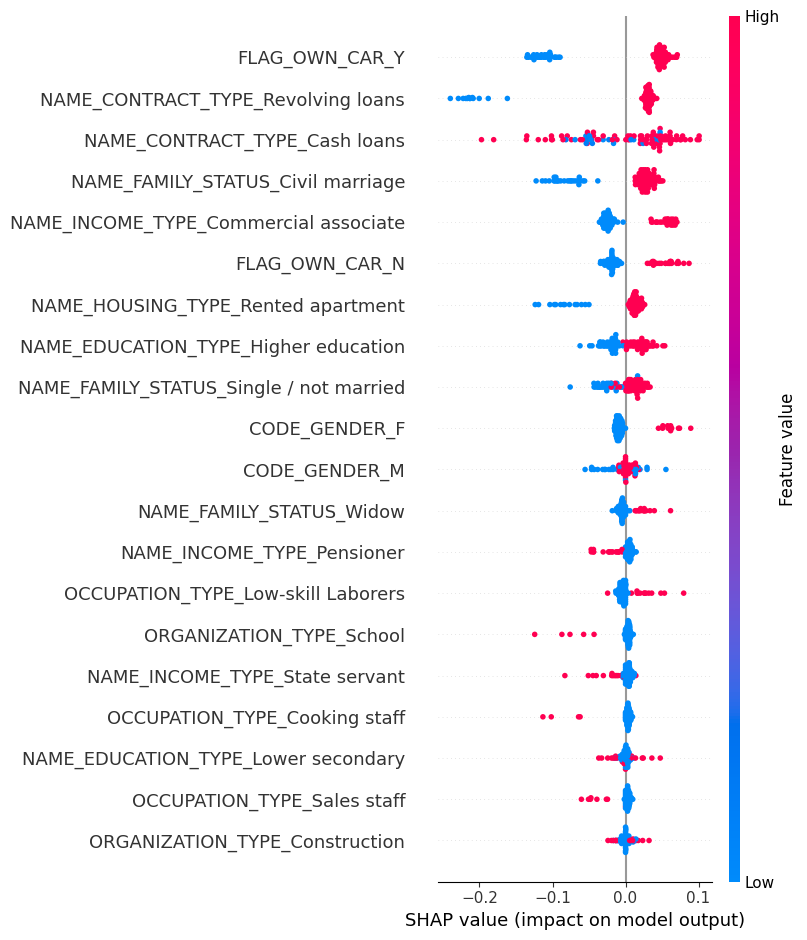

In [56]:
# Créer un échantillon aléatoire de 100 lignes à partir des données de test pour SHAP
X_sample = final_X_test_selected_voting_clf[np.random.choice(final_X_test_selected_voting_clf.shape[0], size=100, replace=False)]

# Convertir X_sample en DataFrame avec les bons noms de colonnes
X_sample_df = pd.DataFrame(X_sample, columns=selected_features_final)

# Créer une fonction de prédiction
def predict_fn(data):
    return best_voting_clf.predict_proba(data)[:, 1]  # Assurez-vous d'utiliser predict_proba

# Initialiser KernelExplainer avec la fonction de prédiction
explainer = shap.KernelExplainer(predict_fn, X_sample_df)

# Calculer les valeurs SHAP pour l'échantillon sélectionné
shap_values = explainer.shap_values(X_sample_df)

# Visualisation des valeurs SHAP
shap.summary_plot(shap_values, X_sample_df)

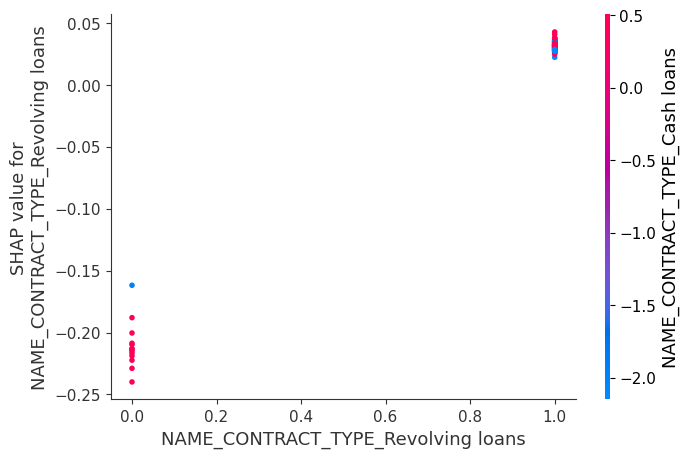

In [58]:
shap.dependence_plot("NAME_CONTRACT_TYPE_Revolving loans", shap_values, X_sample_df)

## Interprétation des Résultats SHAP

### 1. Valeurs SHAP par Caractéristique

La première partie des résultats montre les valeurs SHAP pour différentes caractéristiques pour quelques instances (lignes). Chaque valeur représente l'impact d'une caractéristique sur la prédiction du modèle pour une instance donnée.

- **Valeurs Positives** : Une valeur SHAP positive indique que la caractéristique contribue à augmenter la probabilité que l'instance soit classée dans la classe positive (par exemple, "approuvé").
- **Valeurs Négatives** : Une valeur SHAP négative indique que la caractéristique contribue à diminuer cette probabilité.

### Exemple d'Interprétation :

- Pour l'instance 1 :
  - `NAME_CONTRACT_TYPE_Revolving loans` a une valeur SHAP de `-0.200394`, ce qui signifie qu'elle a un impact négatif significatif sur la probabilité que cette instance soit classée comme "approuvé".
  - `FLAG_OWN_CAR_Y` a une valeur de `-0.118219`, indiquant également un effet négatif.

## 2. Résumé des Valeurs SHAP

La seconde partie des résultats résume les valeurs SHAP moyennes pour chaque caractéristique, ce qui vous permet de voir quelles caractéristiques ont le plus grand impact global sur le modèle.

### Exemple d'Interprétation :

- **`NAME_FAMILY_STATUS_Married`** : Avec une valeur moyenne de `0.000493`, cela indique qu'être marié a un léger effet positif sur la probabilité d'approbation.
- **`ORGANIZATION_TYPE_Police`** : Avec une valeur moyenne de `0.000352`, cela suggère également un léger effet positif.
- **`FLAG_OWN_CAR_Y`** : Avec une valeur moyenne de `-0.000533`, cela indique que posséder une voiture a un effet légèrement négatif sur la probabilité d'approbation.

## Conclusion Générale

En examinant ces résultats, on peut tirer plusieurs conclusions :

1. **Caractéristiques Importantes** : Identifiez les caractéristiques qui ont les valeurs SHAP moyennes les plus élevées (positives ou négatives) pour comprendre quelles variables influencent le plus votre modèle.
2. **Amélioration du Modèle** : Si certaines caractéristiques ont des impacts négatifs significatifs, envisagez d'explorer pourquoi cela se produit et si des ajustements peuvent être faits dans le prétraitement ou dans le modèle lui-même.
3. **Interprétabilité** : Les valeurs SHAP fournissent une interprétation claire de la façon dont chaque caractéristique influence les prédictions, ce qui est essentiel pour des applications sensibles comme le scoring de crédit.



In [65]:
# Vérifiez les longueurs
print(len(y_pred), len(y_test), len(X_sample_df))


40304 40304 100


# Data Drift

In [77]:
# Vérification et gestion des NaN
if train_data.isnull().values.any():
    print("Des NaN ont été trouvés dans train_data.")
    train_data.fillna(0, inplace=True)  # Remplacer par 0 ou une autre méthode

if test_data.isnull().values.any():
    print("Des NaN ont été trouvés dans test_data.")
    test_data.fillna(0, inplace=True)  # Remplacer par 0 ou une autre méthode

# Détection de Dérive des Données (Data Drift)
# Vérifier si 'TARGET' existe dans train_data avant de le supprimer
if 'TARGET' in train_data.columns:
    ref_df = train_data.drop(columns=['TARGET'])  # Référence sans la cible
else:
    raise ValueError("La colonne 'TARGET' n'existe pas dans train_data.")

# Vérifier si 'TARGET' existe dans test_data avant de le supprimer
if 'TARGET' in test_data.columns:
    cur_df = test_data.drop(columns=['TARGET'])  # Données actuelles sans la cible
else:
    cur_df = test_data.copy()  # Utiliser test_data tel quel si TARGET n'existe pas

# Suppression des avertissements d'overflow lors de l'exécution du rapport
with np.errstate(over='ignore', divide='ignore', invalid='ignore'):
    data_drift_dataset_report = Report(metrics=[DataDriftTable()])
    data_drift_dataset_report.run(reference_data=ref_df, current_data=cur_df)

# Afficher le rapport
data_drift_dataset_report.show(mode='inline')